In [1]:
from decoder_new import *
from encoder import *
from data_loader import *
import pickle
import random
import torch.optim as optim
from torch.autograd import Variable
import csv
import time
from tqdm import tqdm
import gc
import os
import torchvision.transforms as tf
import json
from torch.nn.utils.rnn import pack_padded_sequence
from nltk.translate.bleu_score import corpus_bleu
from matplotlib import pyplot as plt


[nltk_data] Downloading package punkt to
[nltk_data]     /datasets/home/62/762/ajabaren/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:


def validate_test(val_loader, encoder, decoder, criterion, maxSeqLen,
             vocab, use_gpu = True, calculate_bleu = True):

    
    #Evaluation Mode
    decoder.eval()
    encoder.eval()

    
    use_gpu = torch.cuda.is_available()

    references = list()
    hypotheses = list() 
    
    if use_gpu:
        device = torch.device("cuda:0")
        
        
    with torch.no_grad():
        
        count    = 0
        loss_avg = 0
        bleu1_avg = 0
        bleu4_avg = 0
        
        for i, (inputs, caps, caplens, allcaps) in enumerate(val_loader):

            # Move to device, if available
            if use_gpu:
                inputs = inputs.to(device)
                caps = caps.to(device)

                        
            enc_out = encoder(inputs)
            actual_lengths = allcaps
            
            
            
            temperature = 1
            test_pred = decoder.generate_caption(enc_out, maxSeqLen, temperature)

            test_pred_sample = test_pred[0].cpu().numpy()          

            

            
            #Build a list of the predicted sentences
            # Convert word_ids to words
            sampled_caption = []

            for word_id in test_pred_sample:
                word = vocab.idx2word[word_id]
                sampled_caption.append(word)
                if word == '<end>':
                    break
            sentence = ' '.join(sampled_caption)
            hypotheses.append(sampled_caption)                
            #if i % 750 ==0:
                #print ('generated sentence: ',sentence)            
                #print(type(sampled_caption))        
                #print(sampled_caption)        
                #print('len(generated_sentence): ',len(sampled_caption))

                
            #targets = pack_padded_sequence(labels, lengths, batch_first=True)[0]
        
            outputs = decoder(caps, enc_out, actual_lengths)
#             if i % 1000 == 0:
#                 print('VAL: outputs shape: ', outputs.size())
            new_outputs = torch.zeros(inputs.shape[0], maxSeqLen, vocab.idx)
            new_outputs[:inputs.shape[0],:maxSeqLen, 0] = torch.ones((inputs.shape[0], maxSeqLen))
#             for dim in range(maxSeqLen):
#                 for b in range(inputs.shape[0]):
#                     new_outputs[b, dim, 0] = 1.0
            new_outputs[:, :(outputs.shape[1]), :] = outputs
            new_outputs = new_outputs.permute(0, 2, 1).to(device)
            
            #del inputs

            
            loss = criterion(new_outputs, Variable(caps.long()))
            loss_avg += loss
            count+=1
            
            #del outputs            
            
            #print('VAL: loss: ', loss)

            
            
            caps_array = caps.cpu().numpy()  
            # Convert word_ids to words
            reference_caption = []
            sampled_caption = []
            
            for word_id in caps_array[0]:
                word = vocab.idx2word[word_id]
                reference_caption.append(word)
                if word == '<end>':
                    break
            ref_sentence = ' '.join(reference_caption)
            #if i % 500 == 0:
                #print('ref_sentence: ', ref_sentence)
                #print('len(ref_sentence): ',len(reference_caption))
            references.append(reference_caption)   
        

        
        
            #print('len(references)', len(references))
            #print('len(hypotheses)', len(hypotheses))
            #print('references: ', references)
            #print('hypotheses: ', hypotheses)
        

            # Calculate BLEU-4 scores
            if calculate_bleu:
                bleu4 = corpus_bleu(references, hypotheses)                
                bleu1 = corpus_bleu(references, hypotheses,weights=(1.0, 0, 0, 0))
                #print('bleu4: ', bleu4)        
                #print('bleu1: ', bleu1)  
                bleu4_avg+=bleu4
                bleu1_avg+=bleu1
            
            del caps
            del outputs            
            
            
            #if i % 100 == 0:
            #    break
                
                
        if calculate_bleu:
            loss_avg  = loss_avg/count
            bleu4_avg = bleu4_avg/count
            bleu1_avg = bleu1_avg/count 
            #print('VAL: loss_avg: ', loss_avg)
            #print('VAL: bleu4_avg: ', bleu4_avg)
            #print('VAL: bleu1_avg: ', bleu1_avg)
        
        
        
        
            
    return loss_avg, bleu1_avg, bleu4_avg

In [3]:
def trainEncoderDecoder(encoder, decoder, criterion, epochs,
                        train_loader,val_loader, test_loader,
                        name, batch_size, maxSeqLen, vocab):
    
    #Create non-existing logfiles
    logname = './logs/' + name + '.log'
    i = 0
    if os.path.exists(logname) == True:
        
        logname = './logs/' + name + str(i) + '.log'
        while os.path.exists(logname):
            i+=1
            logname = './logs/' + name + str(i) + '.log'

    print('Loading results to logfile: ' + logname)
    with open(logname, "w") as file:
        file.write("Log file DATA: Validation Loss and Accuracy\n") 
    
    logname_summary = './logs/' + name + '_summary' + str(i) + '.log'    
    print('Loading Summary to : ' + logname_summary) 
    
    parameters = list(encoder.fc.parameters())
    parameters.extend(list(decoder.parameters()))
    optimizer = optim.Adam(parameters, lr=5e-3)
    use_gpu = torch.cuda.is_available()
    if use_gpu:
        device = torch.device("cuda:0")
#         encoder = torch.nn.DataParallel(encoder)
#         decoder = torch.nn.DataParallel(decoder)
        
        encoder.to(device)
        decoder.to(device)
        
        
    
    val_loss_set = []
    val_bleu1_set = []
    val_bleu4_set = []
    
    
    training_loss = []
    
    # Early Stop criteria
    minLoss = 1e6
    minLossIdx = 0
    earliestStopEpoch = 10
    earlyStopDelta = 5
    for epoch in range(epochs):
        ts = time.time()

        #import pdb; pdb.set_trace()                     
        for iter, (inputs, labels, lengths, actual_lengths) in tqdm(enumerate(train_loader)):

            optimizer.zero_grad()
            
            
            encoder.train()
            decoder.train()
            
            if use_gpu:
                inputs = inputs.to(device)# Move your inputs onto the gpu
                labels = labels.to(device) # Move your labels onto the gpu
            
                
            enc_out = encoder(inputs)
            #print('enc out shape: ', enc_out.size())
            temperature = 1
#             test_pred = decoder.generate_caption(enc_out, maxSeqLen, temperature)
#             for b in range(batch_size):
#                 flag = False
#                 for wi in range(maxSeqLen):
#                     if test_pred[b, wi] == 2:
#                         flag = True
#                     if flag:
#                         test_pred[b, wi] = 0
            #print('test pred: ', test_pred)
            #print('test pred shape: ', test_pred.size())
            
#             targets = pack_padded_sequence(labels, lengths, batch_first=True)[0]
            
            
            outputs = decoder(labels, enc_out, actual_lengths) #calls forward
#             print('outputs shape: ', outputs.size())
            new_outputs = torch.zeros(inputs.shape[0], maxSeqLen, vocab.idx)
            new_outputs[:inputs.shape[0],:maxSeqLen, 0] = torch.ones((inputs.shape[0], maxSeqLen))
#             for dim in range(maxSeqLen):
#                 for b in range(inputs.shape[0]):
#                     new_outputs[b, dim, 0] = 1.0
            new_outputs[:, :(outputs.shape[1]), :] = outputs
            new_outputs = new_outputs.permute(0, 2, 1).to(device)
#             print('new outputs shape: ', new_outputs.size())
#             print('labels shape: ', labels.size())
            
            loss = criterion(new_outputs, Variable(labels.long()))
            del labels
            del outputs

            loss.backward()
#             loss = loss#.item()
            optimizer.step()

            if iter % 100 == 0:
                print("epoch{}, iter{}, loss: {}".format(epoch, iter, loss))
                break #TODO drop
                
        print("epoch{}, iter{}, loss: {}, epoch duration: {}".format(epoch, iter, loss, time.time() - ts))
        test_pred = decoder.generate_caption(enc_out, maxSeqLen, temperature).cpu()

        for b in range(inputs.shape[0]):
            caption = (" ").join([vocab.idx2word[x.item()] for x in test_pred[b]])
            img = tf.ToPILImage()(inputs[b,:,:,:].cpu())
            plt.imshow(img)
                    
            plt.show()
            print("Caption: " + caption)

        
        # calculate val loss each epoch
        val_loss, val_bleu1, val_bleu4  = validate_test(val_loader, encoder, decoder, criterion,maxSeqLen,
                             vocab, use_gpu)
        val_loss_set.append(val_loss)
        val_bleu1_set.append(val_bleu1)
        val_bleu4_set.append(val_bleu4)
        
        
#         print("epoch {}, time {}, train loss {}, val loss {}, val acc {}, val iou {}".format(epoch, time.time() - ts,
#                                                                                                loss, val_loss,
#                                                                                                val_acc,
#                                                                                                val_iou))        
        training_loss.append(loss)
    
        torch.save(encoder, 'weights_base/encoder_epoch{}')
        torch.save(decoder, 'weights_base/decoder_epoch{}')
        
        with open(logname, "a") as file:
            file.write("writing!\n")
            file.write("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
            file.write("\n training Loss:   " + str(loss.item()))
            file.write("\n Validation Loss: " + str(val_loss_set[-1]))
            file.write("\n Validation bleu1:  " + str(val_bleu1_set[-1]))
            file.write("\n Validation bleu4:  " + str(val_bleu4_set[-1]) + "\n ")                                             
                                                                                                
                                                                                                
        
        # Early stopping
#         if val_loss < minLoss:
#             # Store new best
#             torch.save(model, name)
#             minLoss = val_loss#.item()
#             minLossIdx = epoch
            
        # If passed min threshold, and no new min has been reached for delta epochs
#         elif epoch > earliestStopEpoch and (epoch - minLossIdx) > earlyStopDelta:
#             print("Stopping early at {}".format(minLossIdx))
#             break
        

        
        
    with open(logname_summary, "a") as file:
            file.write("Summary!\n")
            file.write("Stopped early at {}".format(minLossIdx))
            file.write("\n training Loss:   " + str(training_loss))        
            file.write("\n Validation Loss : " + str(val_loss_set))
            file.write("\n Validation bleu1:  " + str(val_bleu1_set))
            file.write("\n Validation bleu4:  " + str(val_bleu4_set) + "\n ")
            
        
    #return val_loss_set, val_acc_set, val_iou_set

loading annotations into memory...
Done (t=0.66s)
creating index...
index created!
loading annotations into memory...
Done (t=0.77s)
creating index...
index created!
loading annotations into memory...
Done (t=0.32s)
creating index...
index created!
Loading results to logfile: ./logs/LSTM2.log
Loading Summary to : ./logs/LSTM_summary2.log


0it [00:00, ?it/s]

epoch0, iter0, loss: 8.569475173950195


epoch0, iter0, loss: 8.569475173950195, epoch duration: 11.151071071624756


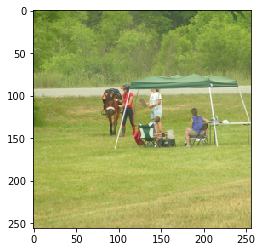

Caption: <start> a crossing glazed dental wetsuits raft set-up blenders occupying square italian adventure neck close pita master current becoming landscape saluting engaging drizzling couscous patient expose spotlight envelopes snack war dust gowns carpets button tinsel trick guests arguing tvs boulder fixing hunching affectionately seats seats seats seats seats seats seats seats seats seats seats seats seats


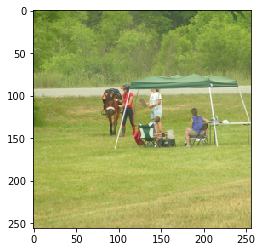

Caption: <start> a crossing glazed dental wetsuits raft set-up blenders occupying square italian adventure neck close pita master current becoming landscape saluting engaging drizzling couscous patient expose spotlight envelopes snack war dust gowns carpets button tinsel trick guests arguing tvs boulder fixing hunching affectionately seats seats seats seats seats seats seats seats seats seats seats seats seats


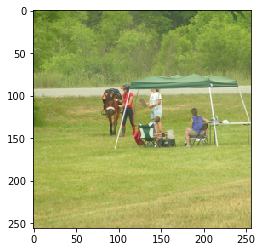

Caption: <start> a crossing glazed dental wetsuits raft set-up blenders occupying square italian adventure neck close pita master current becoming landscape saluting engaging drizzling couscous patient expose spotlight envelopes snack war dust gowns carpets button tinsel trick guests arguing tvs boulder fixing hunching affectionately seats seats seats seats seats seats seats seats seats seats seats seats seats


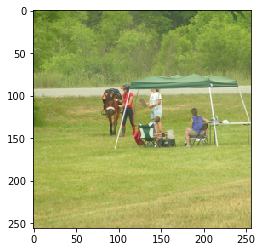

Caption: <start> a crossing glazed dental wetsuits raft set-up blenders occupying square italian adventure neck close pita master current becoming landscape saluting engaging drizzling couscous patient expose spotlight envelopes snack war dust gowns carpets button tinsel trick guests arguing tvs boulder fixing hunching affectionately seats seats seats seats seats seats seats seats seats seats seats seats seats


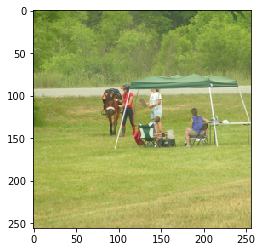

Caption: <start> a crossing glazed dental wetsuits raft set-up blenders occupying square italian adventure neck close pita master current becoming landscape saluting engaging drizzling couscous patient expose spotlight envelopes snack war dust gowns carpets button tinsel trick guests arguing tvs boulder fixing hunching affectionately seats seats seats seats seats seats seats seats seats seats seats seats seats


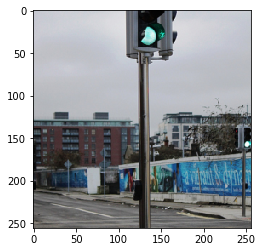

Caption: <start> a crossing glazed dental wetsuits raft set-up blenders occupying square italian adventure neck close pita master current becoming landscape saluting engaging drizzling couscous patient expose spotlight envelopes snack war dust gowns carpets button tinsel trick guests arguing tvs boulder fixing hunching affectionately seats seats seats seats seats seats seats seats seats seats seats seats seats


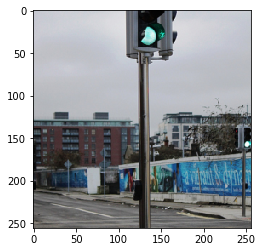

Caption: <start> a crossing glazed dental wetsuits raft set-up blenders occupying square italian adventure neck close pita master current becoming landscape saluting engaging drizzling couscous patient expose spotlight envelopes snack war dust gowns carpets button tinsel trick guests arguing tvs boulder fixing hunching affectionately seats seats seats seats seats seats seats seats seats seats seats seats seats


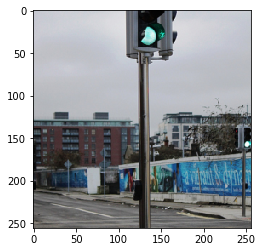

Caption: <start> a crossing glazed dental wetsuits raft set-up blenders occupying square italian adventure neck close pita master current becoming landscape saluting engaging drizzling couscous patient expose spotlight envelopes snack war dust gowns carpets button tinsel trick guests arguing tvs boulder fixing hunching affectionately seats seats seats seats seats seats seats seats seats seats seats seats seats


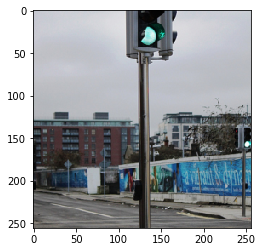

Caption: <start> a crossing glazed dental wetsuits raft set-up blenders occupying square italian adventure neck close pita master current becoming landscape saluting engaging drizzling couscous patient expose spotlight envelopes snack war dust gowns carpets button tinsel trick guests arguing tvs boulder fixing hunching affectionately seats seats seats seats seats seats seats seats seats seats seats seats seats


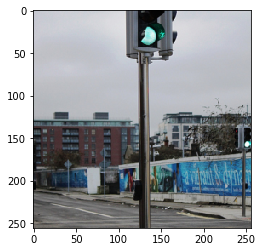

Caption: <start> a crossing glazed dental wetsuits raft set-up blenders occupying square italian adventure neck close pita master current becoming landscape saluting engaging drizzling couscous patient expose spotlight envelopes snack war dust gowns carpets button tinsel trick guests arguing tvs boulder fixing hunching affectionately seats seats seats seats seats seats seats seats seats seats seats seats seats


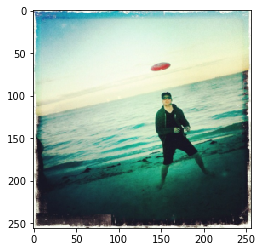

Caption: <start> a crossing glazed dental wetsuits raft set-up blenders occupying square italian adventure neck close pita master current becoming landscape saluting engaging drizzling couscous patient expose spotlight envelopes snack war dust gowns carpets button tinsel trick guests arguing tvs boulder fixing hunching affectionately seats seats seats seats seats seats seats seats seats seats seats seats seats


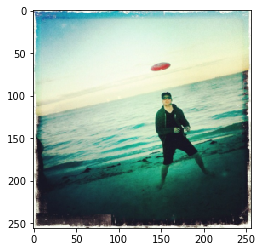

Caption: <start> a crossing glazed dental wetsuits raft set-up blenders occupying square italian adventure neck close pita master current becoming landscape saluting engaging drizzling couscous patient expose spotlight envelopes snack war dust gowns carpets button tinsel trick guests arguing tvs boulder fixing hunching affectionately seats seats seats seats seats seats seats seats seats seats seats seats seats


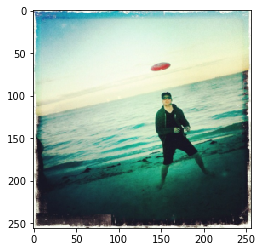

Caption: <start> a crossing glazed dental wetsuits raft set-up blenders occupying square italian adventure neck close pita master current becoming landscape saluting engaging drizzling couscous patient expose spotlight envelopes snack war dust gowns carpets button tinsel trick guests arguing tvs boulder fixing hunching affectionately seats seats seats seats seats seats seats seats seats seats seats seats seats


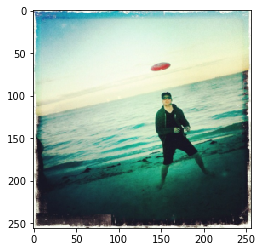

Caption: <start> a crossing glazed dental wetsuits raft set-up blenders occupying square italian adventure neck close pita master current becoming landscape saluting engaging drizzling couscous patient expose spotlight envelopes snack war dust gowns carpets button tinsel trick guests arguing tvs boulder fixing hunching affectionately seats seats seats seats seats seats seats seats seats seats seats seats seats


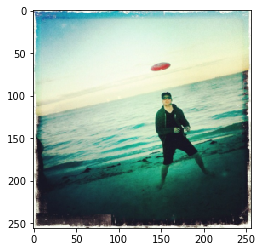

Caption: <start> a crossing glazed dental wetsuits raft set-up blenders occupying square italian adventure neck close pita master current becoming landscape saluting engaging drizzling couscous patient expose spotlight envelopes snack war dust gowns carpets button tinsel trick guests arguing tvs boulder fixing hunching affectionately seats seats seats seats seats seats seats seats seats seats seats seats seats


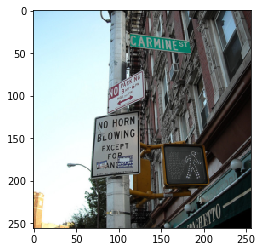

Caption: <start> a crossing glazed dental wetsuits raft set-up blenders occupying square italian adventure neck close pita master current becoming landscape saluting engaging drizzling couscous patient expose spotlight envelopes snack war dust gowns carpets button tinsel trick guests arguing tvs boulder fixing hunching affectionately seats seats seats seats seats seats seats seats seats seats seats seats seats


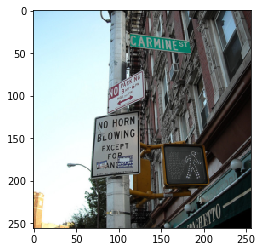

Caption: <start> a crossing glazed dental wetsuits raft set-up blenders occupying square italian adventure neck close pita master current becoming landscape saluting engaging drizzling couscous patient expose spotlight envelopes snack war dust gowns carpets button tinsel trick guests arguing tvs boulder fixing hunching affectionately seats seats seats seats seats seats seats seats seats seats seats seats seats


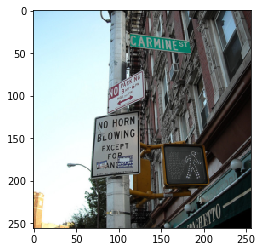

Caption: <start> a crossing glazed dental wetsuits raft set-up blenders occupying square italian adventure neck close pita master current becoming landscape saluting engaging drizzling couscous patient expose spotlight envelopes snack war dust gowns carpets button tinsel trick guests arguing tvs boulder fixing hunching affectionately seats seats seats seats seats seats seats seats seats seats seats seats seats


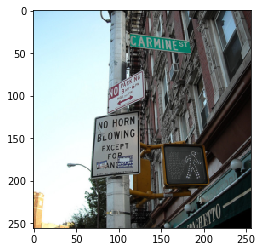

Caption: <start> a crossing glazed dental wetsuits raft set-up blenders occupying square italian adventure neck close pita master current becoming landscape saluting engaging drizzling couscous patient expose spotlight envelopes snack war dust gowns carpets button tinsel trick guests arguing tvs boulder fixing hunching affectionately seats seats seats seats seats seats seats seats seats seats seats seats seats


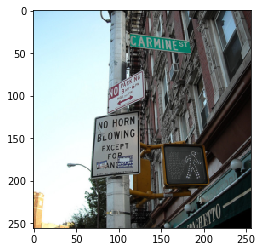

Caption: <start> a crossing glazed dental wetsuits raft set-up blenders occupying square italian adventure neck close pita master current becoming landscape saluting engaging drizzling couscous patient expose spotlight envelopes snack war dust gowns carpets button tinsel trick guests arguing tvs boulder fixing hunching affectionately seats seats seats seats seats seats seats seats seats seats seats seats seats


/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

In [ ]:
if __name__=='__main__':
    with open('TrainImageIds.csv', 'r') as f:
        reader = csv.reader(f)
        trainIds = list(reader)[0]
        
    with open('TestImageIds.csv', 'r') as f:
        reader = csv.reader(f)
        testIds = list(reader)[0]
    
    trainIds = [int(i) for i in trainIds]
    testIds = [int(i) for i in testIds]
    
    # Will shuffle the trainIds incase of ordering in csv
    random.shuffle(trainIds)
    splitIdx = int(len(trainIds)/5)
    
    # Selecting 1/5 of training set as validation
    valIds = trainIds[:splitIdx]
    trainIds = trainIds[splitIdx:]
    #print(trainIds)
    
    
    trainValRoot = "./data/images/train/"
    testRoot = "./data/images/test/"
    
    trainValJson = "./data/annotations/captions_train2014.json"
    testJson = "./data/annotations/captions_val2014.json"
    
    
    with open('./data/vocab.pkl', 'rb') as f:
        vocab = pickle.load(f)
    
    img_side_length = 256
    transform = tf.Compose([
        tf.Resize(img_side_length),
        #tf.RandomCrop(img_side_length),
        tf.CenterCrop(img_side_length),
        tf.ToTensor(),
    ])
    batch_size = 20
    shuffle = True
    num_workers = 20
    
    
    trainDl = get_loader(trainValRoot, trainValJson, trainIds, vocab, 
                         transform=transform, batch_size=batch_size, 
                         shuffle=False, num_workers=num_workers)
    valDl = get_loader(trainValRoot, trainValJson, valIds, vocab, 
                         transform=transform, batch_size=batch_size, 
                         shuffle=shuffle, num_workers=num_workers)
    testDl = get_loader(testRoot, testJson, testIds, vocab, 
                        transform=transform, batch_size=batch_size, 
                        shuffle=shuffle, num_workers=num_workers)
    
    encoded_feature_dim = 1024
    maxSeqLen = 56
    hidden_dim = 128
    
    encoder = Encoder(encoded_feature_dim)
    # Turn off all gradients in encoder
    for param in encoder.parameters():
        param.requires_grad = False
    # Turn on gradient of final hidden layer for fine tuning
    for param in encoder.fc.parameters():
        param.requires_grad = True
    decoder = Decoder(encoded_feature_dim, 128, hidden_dim, vocab.idx)
    
#     criterion = nn.NLLLoss()
    criterion = nn.CrossEntropyLoss()
    
    epochs = 100
    trainEncoderDecoder(encoder, decoder, criterion, epochs,
                        trainDl, valDl, testDl, "LSTM",
                        batch_size, maxSeqLen, vocab)

    
  

In [ ]:
%debug